# Demonstrate Unscented Kálmán Filter (UKF)
Demonstrate the UKF filter on estimating the resistance of a single-resistor circuit

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from asoh.observers.ukf import UnscentedKalmanFilter
from asoh.models.ecm import ECMControl, ECMOutputs, ECMState, SingleResistorModel
import pandas as pd
import numpy as np

Configuration

In [2]:
actual_rint: float = 0.1  # Actual resistance 
guess_rint: float = 0.05  # Guess for resistance
charge_time: float = 3600.  # Interval over which to charge and discharge the battery
observations_per_charge: int = 60  # How many times to measure voltage during charge
current: float = 1.  # Applied current during charge or discharge
cycle_count: int = 4  # Number of cycles to simulate

## Create the Model
The ASOH package defines a dynamic system with two parts:
1. A "Model" that describes how to update the state of a dynamic system
2. A "State" defining the parameters for a specific system

Our model, which implements an ECM with a single resistor, does not have any controlable variables.

In [3]:
model = SingleResistorModel()

Define the state of the system (e.g., it's charge) and the parameters which define its dynamics using the "State"

In [4]:
actual_state = ECMState(charge=0., r_serial=actual_rint, ocv_params=(1., 0.5))
actual_state

ECMState(health_params=(), covariance=array([[1.]]), state_params=('charge',), charge=0.0, r_serial=0.1, ocv_params=(1.0, 0.5))

The dynamics of a system are controlled by outside forces, which are described by a "Control" class.

Our simple circuit uses only the applied current as control. 

Employ the model to update the state under the influence of this control signal

In [5]:
model.update(state=actual_state, control=ECMControl(current=1.), total_time=3600.)

In [6]:
print(f'Charge after 1 hour of 1 A current: {actual_state.charge:.2f} A-hr')

Charge after 1 hour of 1 A current: 1.00 A-hr


The other function of the model is to predict the observables of a system given the state and control signal.

In [7]:
model.output(actual_state, control=ECMControl(current=-1.))

ECMOutputs(terminal_voltage=1.4)

The terminal voltage is the only observable signal from our system

In [8]:
actual_state.charge = 0.  # Reset to a fully-discharged state

## Estimate the State
State estimation is the process of determing the parameters of a dynamic system given observations of its behavior.

The ASOH package does so using an "observer" class which gradually alters the estimate of a state of a system given many signals over time.

### Defining which Parameters to Estimate
Start with building a guess for the initial state that also lists which parameters of the system we're unsure about marked as the "health params"

In [9]:
state = ECMState(
    charge=0., 
    r_serial=guess_rint, 
    ocv_params=(1., 0.5),
    health_params=('r_serial',),
)
state

ECMState(health_params=('r_serial',), covariance=array([[1., 0.],
       [0., 1.]]), state_params=('charge',), charge=0.0, r_serial=0.05, ocv_params=(1.0, 0.5))

Note that the state includes a covariance, which represents the probability distribution for the parameters we're fitting.

In this case, those parameters are the state of charge of the system and the resistance of the resistor

In [10]:
state.covariance

array([[1., 0.],
       [0., 1.]])

In [11]:
state.full_params

('charge', 'r_serial')

## Using the Observer
Observer classes are tied to a specific model and specific instance being evaluated. Create only by supplying the Model and State to the initial value

In [12]:
ukf = UnscentedKalmanFilter(model, state, covariance_process_noise=np.eye(2,) * 1e-3, covariance_sensor_noise=np.array([[1e-2]]))

All observers define a "step" function that updates the estimate of a state given
the control signal applied at a new step, 
the observed outputs,
and the length of time between this step and the last.

In [13]:
help(ukf.step)

Help on method step in module asoh.observers.ukf:

step(u: asoh.models.base.ControlState, y: asoh.models.base.Outputs, t_step: float) method of asoh.observers.ukf.UnscentedKalmanFilter instance
    Update the state estimation given a new set of control states
    
    Args:
        u: Control states at the new time step
        y: Observed outputs at the new time step
        t_step: Time elapsed between last and current timestep



We'll run very many cycles and record the changes in step after each

In [14]:
time = 0
timestep = charge_time / observations_per_charge
state_names = ('time',) + state.full_params + tuple(f'var_{s}' for s in state.full_params)
full_states = []
while time < cycle_count * charge_time * 2:
    
    # Start by charging
    for step_current in [current, -current]:
        control = ECMControl(current=step_current)
        for i in range(observations_per_charge):
            time += timestep
            model.update(actual_state, control, timestep)
            ukf.step(control, model.output(actual_state, control), timestep)
            full_states.append([time] + state.full_state.tolist() + np.diag(state.covariance).tolist())
        

In [15]:
full_states = pd.DataFrame(full_states, columns=state_names)

Plot the estimated charge

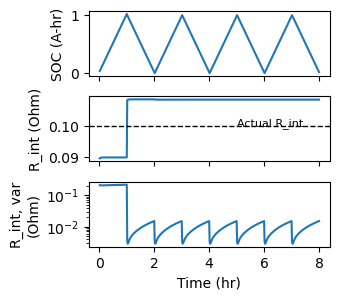

In [16]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3.5, 3.1))

axs[0].plot(full_states['time'] / 3600., full_states['charge'])
axs[0].set_xlim(axs[0].get_xlim())
axs[0].set_ylabel('SOC (A-hr)')

axs[1].plot(full_states['time'] / 3600., full_states['r_serial'])
axs[1].plot(axs[1].get_xlim(), [actual_rint] * 2, 'k--', lw=1)
axs[1].text(5, actual_rint, 'Actual R_int', fontsize=8)
axs[1].set_ylabel('R_int (Ohm)')

axs[2].semilogy(full_states['time'] / 3600., full_states['var_r_serial'])
axs[2].set_ylabel('R_int, var\n(Ohm)')

axs[-1].set_xlabel('Time (hr)')

fig.tight_layout()